Available expiry dates: ('2025-09-05', '2025-09-12', '2025-09-19', '2025-09-26', '2025-10-03', '2025-10-10', '2025-10-17', '2025-11-21', '2025-12-19', '2026-01-16', '2026-02-20', '2026-03-20', '2026-04-17', '2026-05-15', '2026-06-18', '2026-08-21', '2026-09-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17')
Sample call options:
         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  AAPL250905C00110000 2025-08-27 15:40:36+00:00   110.0     119.65  120.20   
1  AAPL250905C00125000 2025-08-15 19:50:00+00:00   125.0     106.65  105.20   
2  AAPL250905C00135000 2025-08-20 16:58:50+00:00   135.0      91.35   95.40   
3  AAPL250905C00140000 2025-08-21 19:17:08+00:00   140.0      85.13   90.40   
4  AAPL250905C00150000 2025-08-25 19:12:39+00:00   150.0      78.00   80.25   

      ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  123.75     0.0            0.0     NaN             3           3.943360   
1  109.05     0.0            0

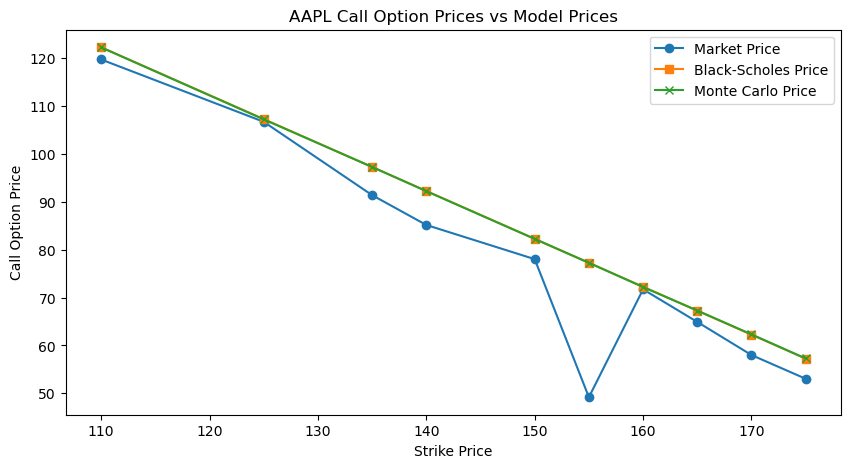

    Strike  Market Price  Implied Volatility
0    210.0         22.16                 NaN
1    212.5         19.90            0.440468
2    215.0         17.05                 NaN
3    217.5         15.42            0.493643
4    220.0         12.56            0.346576
5    222.5         10.25            0.332768
6    225.0          8.15            0.333813
7    227.5          6.11            0.316583
8    230.0          4.31            0.302025
9    232.5          2.85            0.292759
10   235.0          1.71            0.282106
11   237.5          0.91            0.271338
12   240.0          0.45            0.266818
13   242.5          0.20            0.263267
14   245.0          0.10            0.271106
15   247.5          0.04            0.270764
16   250.0          0.03            0.295371
17   252.5          0.02            0.313640
18   255.0          0.02            0.345896


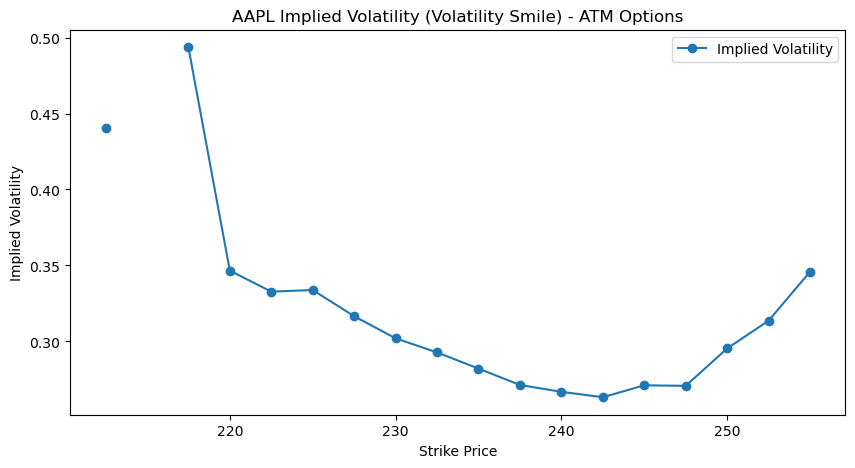

In [25]:
# Real Market Option Pricing (ATM Options)

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
import yfinance as yf

# 1. Download Real Stock Data

ticker = yf.Ticker("AAPL")

# Available expiry dates
expiry_dates = ticker.options
print("Available expiry dates:", expiry_dates)
expiry = expiry_dates[0]  # pick first expiry

# Get option chain
option_chain = ticker.option_chain(expiry)
calls = option_chain.calls
puts = option_chain.puts

print("Sample call options:\n", calls.head())

# Get historical stock prices to compute volatility
data = ticker.history(period="1y")['Close'].dropna()
returns = data.pct_change().dropna()

S_real = data.iloc[-1].item()  # latest stock price as float
sigma_real = returns.std() * np.sqrt(252)  # annualised volatility
r = 0.05  # risk-free rate

print(f"Spot Price: {S_real:.2f}, Annualized Volatility: {sigma_real:.2%}")

# 2. Black-Scholes Call Option Pricing

def black_scholes_call(S, K, T, r, sigma):
    """Black-Scholes European Call Option Price"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    return call_price

# 3. Monte Carlo Simulation

def monte_carlo_call(S, K, T, r, sigma, n_simulations=100000):
    """Monte Carlo simulation for European Call Option"""
    ST = S * np.exp((r - 0.5*sigma**2)*T + sigma*np.sqrt(T)*np.random.randn(n_simulations))
    payoffs = np.maximum(ST - K, 0)
    price = np.exp(-r*T) * np.mean(payoffs)
    return price

# 4. Compare Model Prices to Market Prices

comparison = []
for idx, row in calls.head(10).iterrows():  # first 10 call options
    K = row['strike']
    market_price = row['lastPrice']
    T = (pd.to_datetime(expiry) - pd.Timestamp.today()).days / 252
    bs_price = black_scholes_call(S_real, K, T, r, sigma_real)
    mc_price = monte_carlo_call(S_real, K, T, r, sigma_real, n_simulations=50000)
    comparison.append([K, market_price, bs_price, mc_price])

comparison_df = pd.DataFrame(comparison, columns=['Strike', 'Market Price', 'BS Price', 'Monte Carlo Price'])
print(comparison_df)

# Plot comparison
plt.figure(figsize=(10,5))
plt.plot(comparison_df['Strike'], comparison_df['Market Price'], 'o-', label='Market Price')
plt.plot(comparison_df['Strike'], comparison_df['BS Price'], 's-', label='Black-Scholes Price')
plt.plot(comparison_df['Strike'], comparison_df['Monte Carlo Price'], 'x-', label='Monte Carlo Price')
plt.xlabel("Strike Price")
plt.ylabel("Call Option Price")
plt.title(f"{ticker.ticker} Call Option Prices vs Model Prices")
plt.legend()
plt.show()

# 5. Implied Volatility Calculation (ATM Options)

def implied_volatility_call(C_market, S, K, T, r, sigma_min=1e-6, sigma_max=5):
    """Compute implied volatility using Brent's method with safety check"""
    func = lambda sigma: black_scholes_call(S, K, T, r, sigma) - C_market
    try:
        if func(sigma_min) * func(sigma_max) >= 0:
            return np.nan  # no solution in bounds
        else:
            return brentq(func, sigma_min, sigma_max)
    except:
        return np.nan

# Filter ATM-ish options: within 10% of spot
calls_atm = calls[(calls['strike'] >= S_real*0.9) & (calls['strike'] <= S_real*1.1)]

# Compute implied volatility for ATM-ish options
iv_list = []
for idx, row in calls_atm.iterrows():
    K = row['strike']
    C_market = row['lastPrice']
    T = (pd.to_datetime(expiry) - pd.Timestamp.today()).days / 252
    iv = implied_volatility_call(C_market, S_real, K, T, r)
    iv_list.append([K, C_market, iv])

iv_df = pd.DataFrame(iv_list, columns=['Strike', 'Market Price', 'Implied Volatility'])
print(iv_df)

# Plot Implied Volatility (Volatility Smile)
plt.figure(figsize=(10,5))
plt.plot(iv_df['Strike'], iv_df['Implied Volatility'], 'o-', label='Implied Volatility')
plt.xlabel("Strike Price")
plt.ylabel("Implied Volatility")
plt.title(f"{ticker.ticker} Implied Volatility (Volatility Smile) - ATM Options")
plt.legend()
plt.show()